## <font color='Green'> Group 2 - Image Captioning using CNNs+LSTMs - AIDL END TERM Project </font>
### <font color='Blue'> MBA23196	SAMARTH SINHA </font>
### <font color='Blue'> MBA23328	SPARSH SAHU </font>
### <font color='Blue'> MBA23059	SAMAGYA RATHI </font>
### <font color='Blue'> MBA23219    Ajay Kamboj	</font>
### <font color='Blue'> MBA23072	Vikrant Dixit</font>
### <font color='Blue'> MBA23313	Shivam Khandelwal</font>

## <font color='Green'>Step 1: Basic Setup

### <font color='Green'>Step 1.1:  Importing Libraries </font>

In [ ]:
!pip install wordcloud

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from wordcloud import WordCloud
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

### <font color='Green'>Step 1.2:  Loading the Dataset </font>

In [2]:
image_path = os.getcwd()+'\\Images\\'

data = pd.read_csv("captions.txt")
print(data.shape)
data.head()

(40455, 2)


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


## <font color='Green'> Step 2 - Data Understanding & Preprocessing </font>

### <font color='Green'>Step 2.1: Function to print image and convert it into Array

In [3]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))

    img = img_to_array(img)
    print('Image array shape: ',img.shape)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(len(temp_df)):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(image_path+temp_df.image[i])
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")
    plt.show()

### <font color='Green'>Step 2.2: Display 10 Random Images and their Captions


Image array shape:  (224, 224, 3)
Image array shape:  (224, 224, 3)
Image array shape:  (224, 224, 3)
Image array shape:  (224, 224, 3)
Image array shape:  (224, 224, 3)
Image array shape:  (224, 224, 3)
Image array shape:  (224, 224, 3)
Image array shape:  (224, 224, 3)
Image array shape:  (224, 224, 3)
Image array shape:  (224, 224, 3)


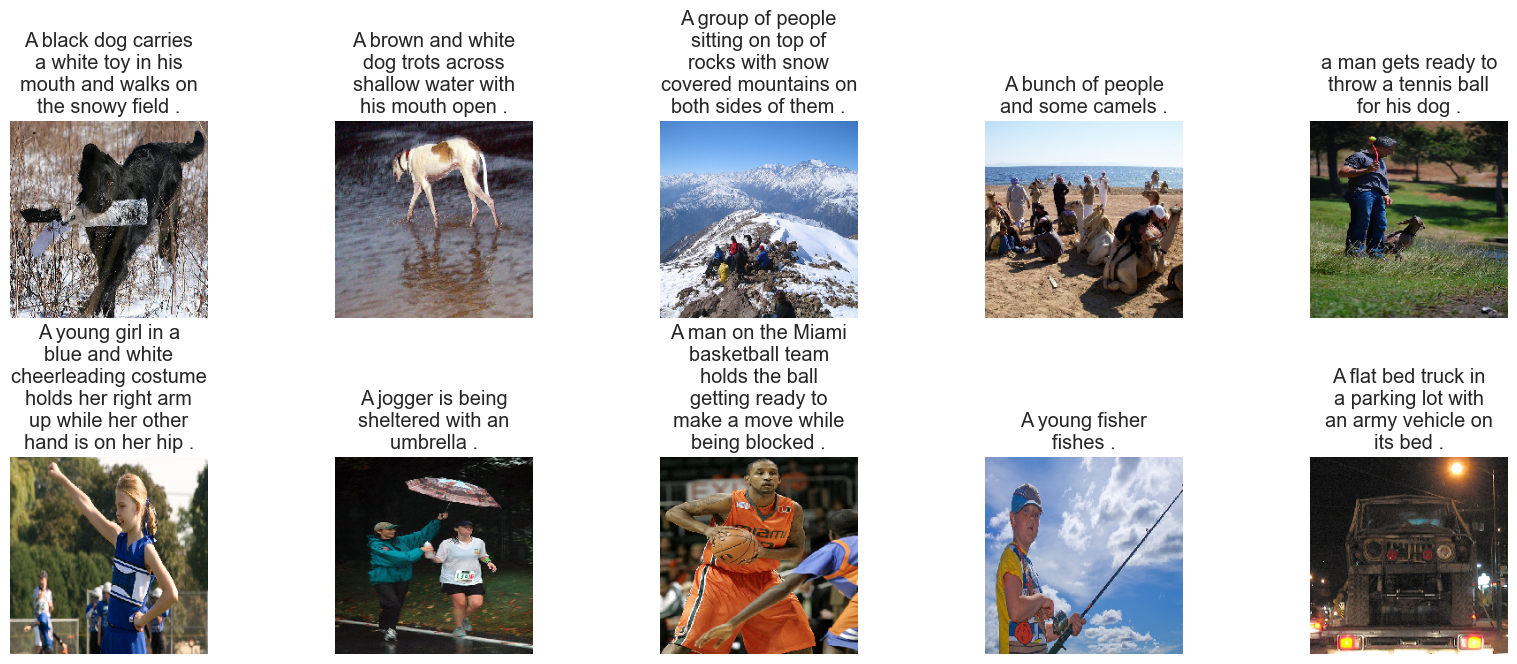

In [4]:
display_images(data.sample(10))

In [5]:
data.sample(5)

,image,caption
9501,244399048_8332bb3270.jpg,A dog is jumping up in the air to catch a toy .
36133,421730441_6b2267fd31.jpg,Man wearing black shirt standing in front of a...
16828,2914331767_8574e7703d.jpg,"Athlete running on field , blurred athletes ru..."
10933,2533010184_ef2fd71297.jpg,A woman wearing a headscarf is near many tulips .
1458,1321723162_9d4c78b8af.jpg,Two girls are ice skating with each other .


### <font color='Green'>Step 2.3: Caption Text Cleaning


In [6]:
mapping = {}

for line in tqdm(data.iterrows()):
    tokens = [line[1].image, line[1].caption]
    
    if len(line) < 2:
        continue
    # Extract the image ID and caption from the tokens    
    image_id, caption = tokens[0], tokens[1:]
    
    caption = " ".join(caption)
    
    if image_id not in mapping:
        mapping[image_id] = []
    
    mapping[image_id].append(caption)

40455it [00:06, 5977.61it/s]


Image array shape:  (224, 224, 3)


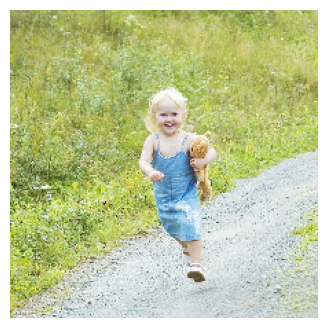

Caption 1 : A Girls Walks Down The Road Holding A Teddy Bear .
Caption 2 : A Little Girl Holding On To A Toy Is Running Down A Lane .
Caption 3 : A Little Girl In A Denim Dress Runs Down A Path .
Caption 4 : A Young Girl Wearing A Blue Dress Runs Down A Gravel Road With A Teddy Bear .
Caption 5 : The Little Girl Is Wearing A Denim Dress And Holding A Brown Teddy Bear .


In [23]:
img = '1337792872_d01a390b33.jpg'

plt.figure(figsize=(5,4))
image = readImage(image_path+img)
plt.imshow(image)
plt.axis("off")
plt.show()
n = 1
for i in mapping[img]:
    print('Caption',n,':',i.replace('startseq ','').title())
    n+=1

In [10]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [11]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
print("Total Words Counts: ",vocab_size)
max_length = max(len(caption.split()) for caption in captions)
print("Max Words Counts per caption: ",max_length)

images = data['image'].unique().tolist()
nimages = len(images)

print('Total unique Images: ',nimages)
split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]



train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

print('Train and Test Data shape: ', train.shape, test.shape)

tokenizer.texts_to_sequences([captions[1]])[0]


Total Words Counts:  8485
Max Words Counts per caption:  34
Total unique Images:  8091
Train and Test Data shape:  (34385, 2) (6070, 2)


[1, 18, 315, 63, 195, 116, 2]

In [13]:
data['caption']

0        startseq child in pink dress is climbing up se...
1          startseq girl going into wooden building endseq
2        startseq little girl climbing into wooden play...
3        startseq little girl climbing the stairs to he...
4        startseq little girl in pink dress going into ...
                               ...                        
40450    startseq man in pink shirt climbs rock face en...
40451    startseq man is rock climbing high in the air ...
40452    startseq person in red shirt climbing up rock ...
40453            startseq rock climber in red shirt endseq
40454    startseq rock climber practices on rock climbi...
Name: caption, Length: 40455, dtype: object

### <font color='Green'> Step 2.4: Word Cloud Generation

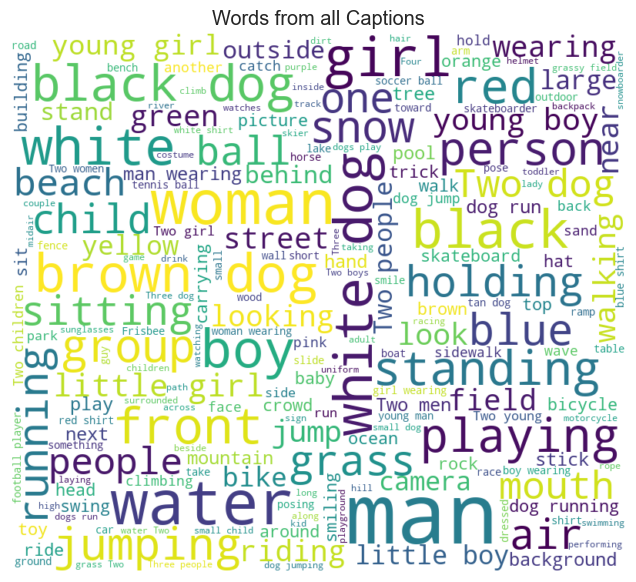

In [24]:
def generate_wordcloud(text_data, title):
    all_words = ' '.join([text for text in text_data])
    
    # Using DejaVuSans font, modify path if necessary
    wordcloud = WordCloud(width=800, height=700, random_state=21, max_font_size=110,background_color = 'White').generate(all_words)
    
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title)
    plt.axis('off')
    plt.show()


generate_wordcloud(data['caption'].str.replace('startseq ','').str.replace(' endseq',''), "Words from all Captions")

## <font color='Green'> Step 3: Model Prepration

### <font color='Green'> Step 3.1: Feature extraction

In [15]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [37:59<00:00,  3.55it/s]


In [16]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

### <font color='Green'>Step 3.2: Modelling

In [17]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

### <font color='Green'> Step 3.3 Model Architechture

In [18]:
#!pip install pydot

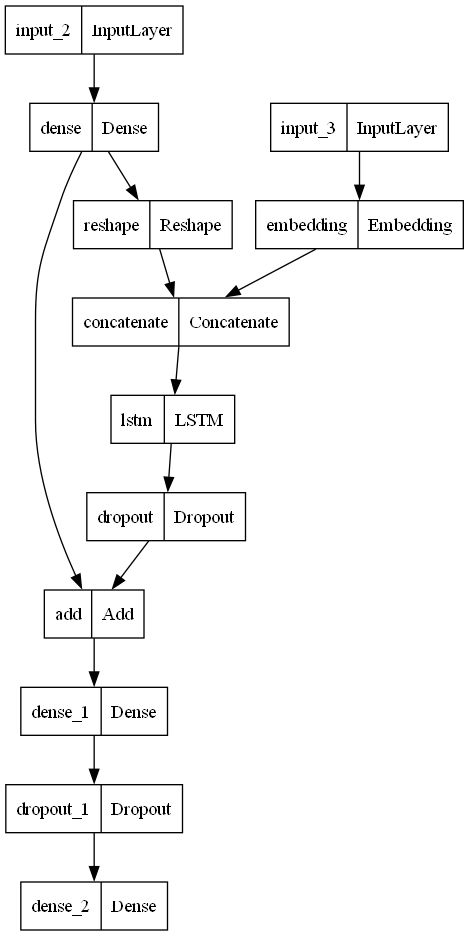

In [19]:
plot_model(caption_model)

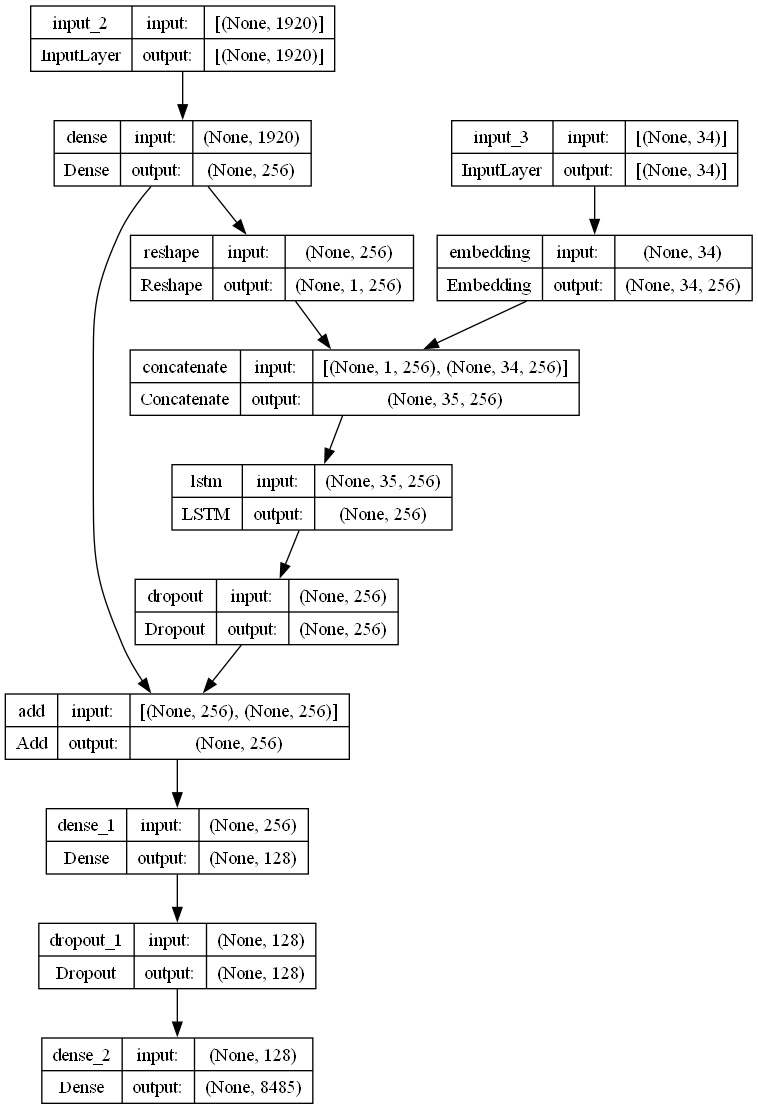

In [20]:
from tensorflow.keras.utils import plot_model

plot_model(caption_model, show_shapes=True, show_layer_names=True)

### <font color='Green'>Step 3.4: Model Summary

In [21]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          491776      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                            

### <font color='Green'>Step 3.5: Training and Testing Data generation

In [22]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [23]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

### <font color='Green'>Step 3.6: Model Training

In [24]:
history = caption_model.fit(
        train_generator,
        epochs=15,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/15
537/537 [==============================] - ETA: 0s - loss: 5.1088
Epoch 1: val_loss improved from inf to 4.21626, saving model to model.h5
537/537 [==============================] - 2219s 4s/step - loss: 5.1088 - val_loss: 4.2163 - lr: 0.0010
Epoch 2/15
537/537 [==============================] - ETA: 0s - loss: 4.1605
Epoch 2: val_loss improved from 4.21626 to 3.88977, saving model to model.h5
537/537 [==============================] - 556s 1s/step - loss: 4.1605 - val_loss: 3.8898 - lr: 0.0010
Epoch 3/15
537/537 [==============================] - ETA: 0s - loss: 3.8921
Epoch 3: val_loss improved from 3.88977 to 3.75364, saving model to model.h5
537/537 [==============================] - 566s 1s/step - loss: 3.8921 - val_loss: 3.7536 - lr: 0.0010
Epoch 4/15
537/537 [==============================] - ETA: 0s - loss: 3.7315
Epoch 4: val_loss improved from 3.75364 to 3.68376, saving model to model.h5
537/537 [==============================] - 572s 1s/step - loss: 3.7315 - val_l

## <font color='Green'> Step 4 - Evaluation of the Model </font>

### <font color='Green'>Step 4.1: Training and Validation Loss Performance

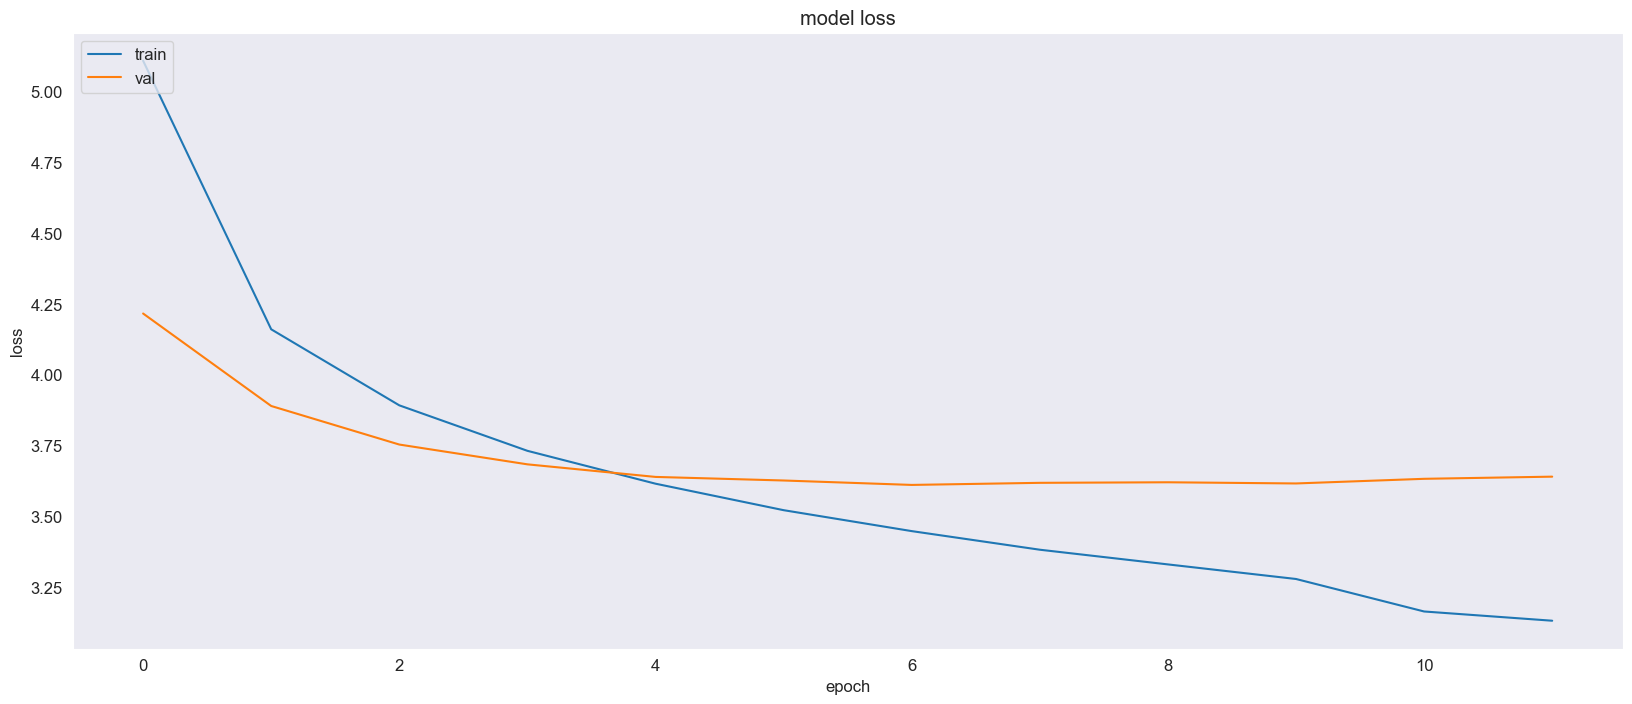

In [25]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

### <font color='Green'>Step 4.2: Prediction function

In [27]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

### <font color='Green'>Step 4.3: Testing the Model on 5 Random images

In [72]:
out = {}
for i in range(5):
    img = test.sample(1)['image'].tolist()[0]
    caption = predict_caption(caption_model, img, tokenizer, max_length, features)
    out[img] = caption



1/1 [==============================] - 0s 56ms/step





Image array shape:  (224, 224, 3)


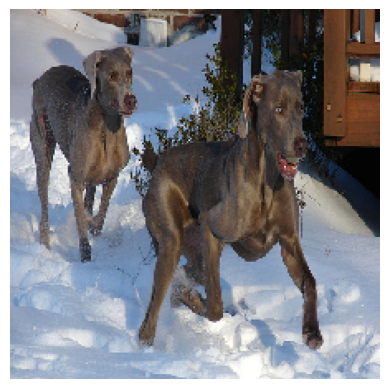

---------------------Actual---------------------
Two Big Brown Dogs Running Through The Snow Endseq
Two Brown Dogs Are Running Over Snow In Line Endseq
Two Brown Dogs Walking Through Snow Endseq
Two Dogs Running In The Snow Endseq
Two Weimaraners Running In The Snow Endseq
---------------------predictd---------------------
Two Dogs Are Running In The Snow Endseq



Image array shape:  (224, 224, 3)


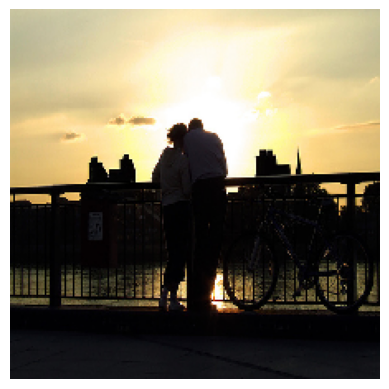

---------------------Actual---------------------
Couple Is Standing Against Railing Looking At Beautiful Lake And Sunset Endseq
Couple Takes In The View At The Water At Dusk Endseq
The Couple Is Standing By The Railing Overlooking The Water Endseq
Two People Stand Against The Railing Above The Water And Watch The Sunset Endseq
Two People Stand Close Together Looking At River From Behind Fence Endseq
---------------------predictd---------------------
Man In Black Jacket Is Standing In Front Of The Sunset Endseq



Image array shape:  (224, 224, 3)


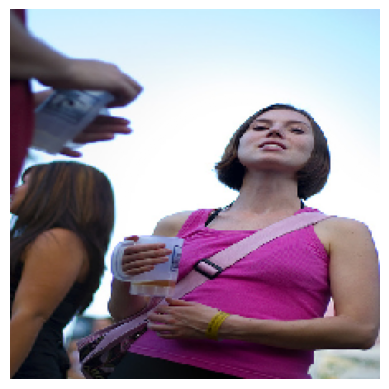

---------------------Actual---------------------
Female In Pink Tank Top Drinking Beer Endseq
Woman In Dark Pink Tank Top Has Bag Across Her Shoulder Endseq
Woman In Pink Tank Top Drinking Out Of Plastic Glass Endseq
Woman In Pink Tank Top Holds Plastic Beer Mug Endseq
Woman Wearing Pink Tank Top Holding Mug Of Liquid Endseq
---------------------predictd---------------------
Woman In Pink Shirt Is Standing In Front Of The Camera Endseq



Image array shape:  (224, 224, 3)


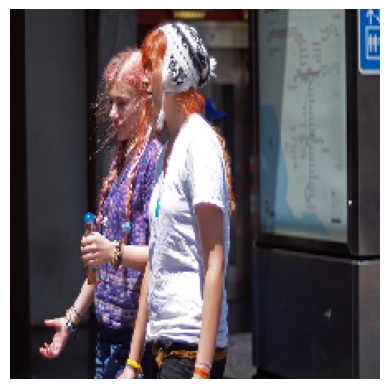

---------------------Actual---------------------
Girls With Orange Hair Standing On The Street With Some Kind Of Bottle In Their Hand Endseq
Two Girls Walking In The Street Endseq
Two Girls Walking Next To Each Other And Talking Endseq
Two Teenage Girls Dressed Like Hippies Walk And Talk Endseq
Two Women One With Head Bandanna Are Standing Next To Each Other While One Holds Bottle Endseq
---------------------predictd---------------------
Woman In Black Shirt And White Shirt Is Standing In Front Of The Camera Endseq



Image array shape:  (224, 224, 3)


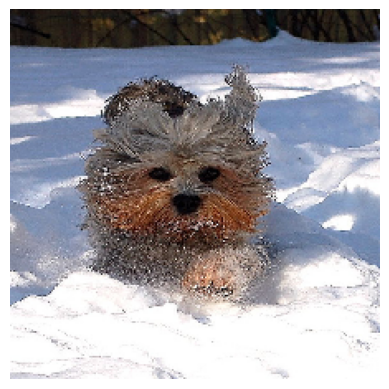

---------------------Actual---------------------
Fluffy Little Dog Running Through The Snow Endseq
An Ash Colored Dog Is Walking Forward In The Snow Endseq
Small Dog Walking Through The Snow Endseq
Small Tan Dog Runs Through The Snow Endseq
Tan Dog Is Walking Through Snow Endseq
---------------------predictd---------------------
Two Dogs Are Playing In The Snow Endseq


In [77]:
for img in out:
    print('')
    print('')
    print('')
    print('==========================================================')
    
    
    image = readImage(image_path+img)
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    print('---------------------Actual---------------------')
    for i in mapping[img]:
        print(i.replace('startseq ','').title())
    print('---------------------predictd---------------------')
    print(out[img].replace('startseq ','').title())

## <font color='Green'> Step 5 - Conclusion </font>

•	Model Performance: The image captioning model demonstrates an ability to generate general descriptions of images, capturing key elements such as objects, colors, and basic actions (e.g., "dogs in snow," "woman in pink shirt"). However, it struggles with more specific and nuanced details.

•	Strengths: The model correctly identifies broad features of images, such as colors, objects, and basic actions (e.g., "two dogs," "woman in pink"). It performs reasonably well in generating captions that are contextually plausible, though they lack specificity.

•	Challenges with Specificity: The model fails to accurately capture specific actions (e.g., "drinking beer," "walking with a bottle"), often producing more generic captions that miss important details. It also struggles with the accurate identification of the number of objects or people in the scene (e.g., incorrectly stating "two dogs" when there is only one).

•	Contextual Understanding: The model struggles to understand and incorporate contextual information, such as the relationships between objects or people (e.g., the relationship between two girls walking together). It tends to focus on surface-level details rather than deeper contextual meanings.

•	Action Recognition: The model has difficulty distinguishing between different actions or understanding the nuances of movements, leading to vague descriptions like "standing in front of the camera" instead of more accurate action descriptions like "drinking" or "walking."

•	Improvement Areas: To enhance the model’s performance, further training is needed, especially focused on improving action recognition, understanding contextual relationships, and accurately capturing specific details in the scene (such as clothing styles or objects held).

•	Generalization vs. Detail: While the model successfully generates general captions, it needs refinement to generate captions that are more detailed and contextually rich, moving beyond surface-level descriptions to accurately capture the complexity of real-world scenes.

•	Future Potential: Despite its limitations, the model shows promise and can be improved with more advanced techniques, such as attention mechanisms or larger, more diverse training datasets, to achieve better performance in real-world image captioning tasks.


## <font color='Green'> Step 6 - Recommendations </font>
1. Focused Data Augmentation: Expand the dataset with diverse and complex images to improve action and object recognition. Augmenting data with a broader range of scenarios will help the model generate more specific captions and better recognize nuanced actions and relationships.

2. Incorporate Attention Mechanisms: Integrating attention mechanisms allows the model to focus on different parts of the image, improving its ability to capture contextual relationships and generate more detailed and relevant captions, especially for complex scenes with multiple objects or people.

3. Enhanced Action Recognition: Improve action recognition by using advanced feature extraction methods (e.g., pre-trained models like ResNet). Fine-tuning the model on specialized datasets for action recognition will enable it to better identify specific actions like "drinking" or "walking."

4. Use of Larger and More Diverse Datasets: Train the model on larger, more varied datasets with detailed captions to help it recognize object relationships and finer details. A diverse dataset ensures better generalization and improves the model’s ability to handle complex scenes accurately.

5. Post-Processing and Error Correction: Implement post-processing techniques like captions filtering and error correction to refine the output. These methods can replace generic phrases with more specific, accurate ones, enhancing the overall quality and reliability of the model’s generated captions.
